<a href="https://colab.research.google.com/github/Rhayem1920/First-End-to-End-ML-Project/blob/main/Ensemble_Learning_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import seaborn as sns
import pandas as pd
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
font={'size': 14,
        'weight' : 'bold',
        'family':'monospace'} # weight could be book,bold etc ...
mpl.rc('font',**font)
sns.set_style('darkgrid')

## Ensemble Learning Methods:
Suppose you ask a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method.


For example, you can train a group of Decision Tree classifiers, each on a different
random subset of the training set. To make predictions, you just obtain the predic‐
tions of all individual trees, then predict the class that gets the most votes.Such an ensemble of Decision Trees is called a Random Forest,
and despite its simplicity, this is one of the most powerful Machine Learning algo‐
rithms available today.


Moreover, you will often use Ensemble methods near
the end of a project, once you have already built a few good predictors, to combine
them into an even better predictor. In fact, the winning solutions in Machine Learn‐
ing competitions often involve several Ensemble methods (most famously in the Net‐
flix Prize competition).
In this chapter we will discuss the most popular Ensemble methods, including bagging, boosting, stacking, and a few others. We will also explore Random Forests.

### Voting Classifiers:

  Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
You may have a Logistic Regression classifier, an SVM classifier, a Random Forest
classifier, a K-Nearest Neighbors classifier, and perhaps a few more.

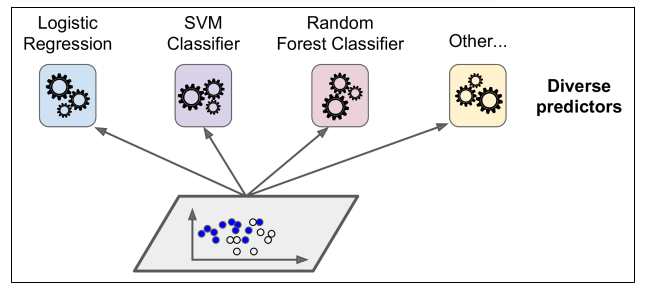

A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier

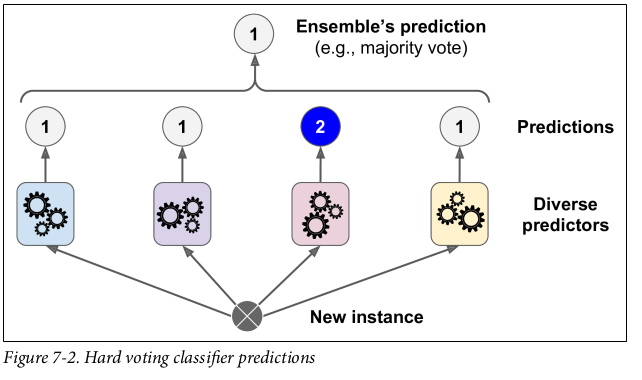

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a
strong learner (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.


How is this possible? The following analogy can help shed some light on this mystery.
Suppose you have a slightly biased coin that has a 51% chance of coming up heads,
and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. If you do the
math, you will find that the probability of obtaining a majority of heads after 1,000
tosses is close to 75%. The more you toss the coin, the higher the probability (e.g.,
with 10,000 tosses, the probability climbs over 97%). This is due to the law of large
numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the
probability of heads (51%). Figure 7-3 shows 10 series of biased coin tosses. You can
see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51%.


In [15]:
pd.DataFrame((np.random.rand(10000, 10)< heads_proba).astype(np.int32)) # 10 series of 1000 coin tosses

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,1,0,0,0,1,1
1,1,0,1,1,1,0,0,1,0,1
2,0,1,0,0,1,1,1,0,1,1
3,0,0,0,0,0,1,1,0,0,1
4,1,1,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
9995,1,1,0,0,1,0,0,1,1,1
9996,1,1,1,0,0,1,0,1,1,0
9997,1,0,0,1,0,1,0,1,0,1
9998,0,0,0,0,0,1,1,1,1,0


In [22]:
pd.DataFrame(np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)) # ratio of heads

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
1,1.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,0.000000,0.500000,0.500000
2,0.666667,0.333333,0.333333,0.666667,1.000000,0.666667,1.000000,0.000000,0.333333,0.666667
3,0.500000,0.500000,0.500000,0.500000,0.750000,0.500000,1.000000,0.250000,0.250000,0.750000
4,0.600000,0.600000,0.600000,0.400000,0.800000,0.400000,1.000000,0.200000,0.200000,0.800000
...,...,...,...,...,...,...,...,...,...,...
9995,0.511405,0.511505,0.506803,0.509304,0.511405,0.504202,0.513806,0.509404,0.510604,0.510204
9996,0.511353,0.511453,0.506852,0.509353,0.511353,0.504251,0.513854,0.509453,0.510653,0.510153
9997,0.511402,0.511502,0.506801,0.509302,0.511402,0.504201,0.513803,0.509502,0.510702,0.510102
9998,0.511351,0.511451,0.506851,0.509351,0.511351,0.504250,0.513751,0.509551,0.510751,0.510151


(0.0, 10000.0, 0.42, 0.58)

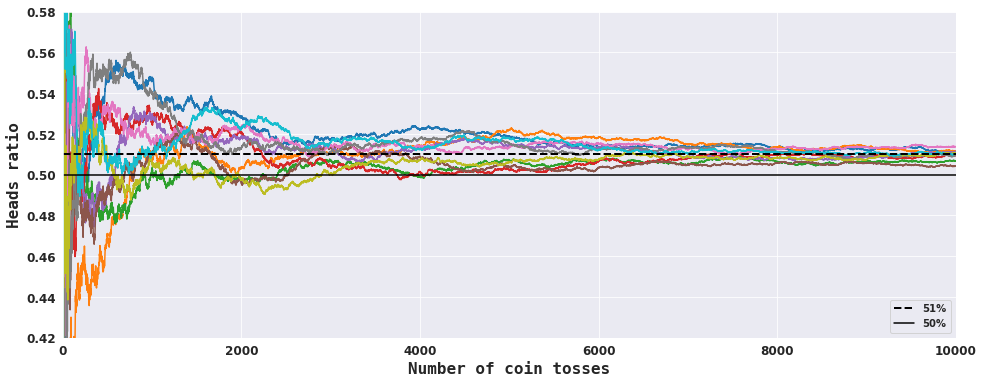

In [14]:
heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
plt.figure(figsize=(16,6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses",fontdict=font,fontsize=16)
plt.ylabel("Heads ratio",fontdict=font,fontsize=16)
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])


Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is
only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case since they are trained on the same data. They are likely to
make the same types of errors, so there will be many majority votes for the wrong
class, reducing the ensemble’s accuracy.

Ensemble methods work best when the predictors are as independ‐
ent from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy.

 **Voting Classifiers**

In [27]:
from sklearn.datasets import make_moons
X,y=make_moons(n_samples=500,noise=0.3,random_state=42)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf=VotingClassifier(estimators=[('lr',log_clf),
                                        ('rf',rnd_clf),
                                        ('svc',svm_clf)],voting='hard')

In [29]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [32]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual classifi‐
ers.
If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called **soft voting.** It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities. This is
not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class prob‐
abilities, slowing down training, and it will add a predict_proba() method). If youmodify the preceding code to use soft voting, you will find that the voting classifier
achieves over 91.2% accuracy!
### **Soft Voting**

In [33]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [34]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### **Bagging and Pasting**:

   One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed.

 Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed with replacement, this method is called bagging 1 (short for
bootstrap aggregating 2 ). When sampling is performed without replacement, it is called
pasting.
In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.

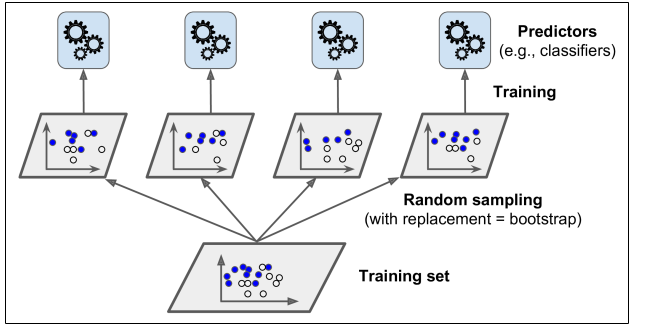

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but
aggregation reduces both bias and variance. 4 Generally, the net result is that the
ensemble has a similar bias but a lower variance than a single predictor trained on the
original training set.


Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas
sifier class (or BaggingRegressor for regression). **The following code trains an
ensemble of 500 Decision Tree classifiers, 5 each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging)**,
but if you want to use pasting instead, just set bootstrap=False ). The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions


In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)


from sklearn.metrics import accuracy_score
print('Bagging Classifier :',accuracy_score(y_test, y_pred))
print('Decision Tree Classifier:',accuracy_score(y_test, y_pred_tree))

Bagging Classifier : 0.904
Decision Tree Classifier: 0.856


Text(0, 0.5, '')

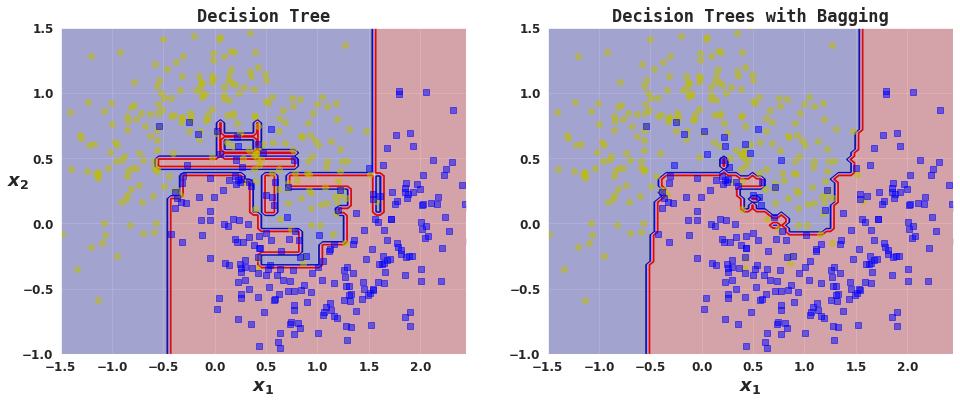

In [59]:

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = 'seismic'
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = 'seismic'
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fix, axes = plt.subplots(ncols=2, figsize=(16,6))

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=17,fontdict=font)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=17,fontdict=font)
plt.ylabel("")

Comparing the decision boundary of a single Decision Tree with the deci‐
sion boundary of a bagging ensemble of 500 trees (from the preceding code), both
trained on the moons dataset. As you can see, the ensemble’s predictions will likely
generalize much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular).

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting, but this also
means that predictors end up being less correlated so the ensemble’s variance is
reduced. Overall, bagging often results in better models, which explains why it is gen‐
erally preferred. However, if you have spare time and CPU power you can use cross-
validation to evaluate both bagging and pasting and select the one that works best.

#### **Out-of-Bag Evaluation**:

 With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement ( bootstrap=True ), where m is the size of the
training set. 
This means that only about 63% of the training instances are sampled on
average for each predictor(As m grows, this ratio approaches 1 – exp(–1) ≈ 63.212%.). The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.


Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.


In Scikit-Learn, you can set **oob_score=True** when creating a BaggingClassifier to
request an automatic oob evaluation after training. 

The following code demonstrates
this. The resulting evaluation score is available through the oob_score_ variable

In [42]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

**The oob decision function for each training instance is also available through the
oob_decision_function_ variable. In this case (since the base estimator has a pre
dict_proba() method) the decision function returns the class probabilities for each
training instance. For example, the oob evaluation estimates that the first training
instance has a 68.25% probability**

In [43]:
pd.DataFrame(bag_clf.oob_decision_function_)

,0,1
0,0.317460,0.682540
1,0.341176,0.658824
2,1.000000,0.000000
3,0.000000,1.000000
4,0.000000,1.000000
...,...,...
370,0.060440,0.939560
371,0.976190,0.023810
372,1.000000,0.000000
373,0.031088,0.968912


**According to this oob evaluation, this BaggingClassifier is likely to achieve about
90.1% accuracy on the test set. Let’s verify this:**

In [44]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.912

**We get 91.2% accuracy on the test set—close enough!**

 The BaggingClassifier class supports sampling the features as well. This is con‐
trolled by two hyperparameters: max_features and bootstrap_features . They work
the same way as max_samples and bootstrap , but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the
input features.
This is particularly useful when you are dealing with high-dimensional inputs (such
as images). 

**Sampling both training instances and features is called the Random
Patches method**.
**Keeping all training instances (i.e., bootstrap=False and max_sam
ples=1.0 ) but sampling features (i.e., bootstrap_features=True and/or max_fea
tures smaller than 1.0) is called the Random Subspaces method**

#### **Random Forest**

  As we have discussed, a Random Forest 9 is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Instead of building a BaggingClassifier and pass‐
ing it a DecisionTreeClassifier , you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees 10 (similarly, there is
a RandomForestRegressor class for regression tasks). The following code trains a
Random Forest classifier with 500 trees (each limited to maximum 16 nodes),


In [45]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a
DecisionTreeClassifier (to control how trees are grown), plus all the hyperpara‐
meters of a BaggingClassifier to control the ensemble itself.(There are a few notable exceptions: splitter is absent (forced to "random" ), presort is absent (forced to
False ), max_samples is absent (forced to 1.0 ), and base_estimator is absent (forced to DecisionTreeClassi
fier with the provided hyperparameters)


The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it
searches for the best feature among a random subset of features. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance,
generally yielding an overall better model. The following BaggingClassifier is
roughly equivalent to the previous RandomForestClassifier


In [46]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

#### **Extra Trees**
  When you are growing a tree in a Random Forest, at each node only a random subset
of the features is considered for splitting (as discussed earlier). 

It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).
A forest of such extremely random trees is simply called an Extremely Randomized
Trees ensemble (or Extra-Trees for short). Once again, this trades more bias for a
lower variance. It also makes Extra-Trees much faster to train than regular Random
Forests since finding the best possible threshold for each feature at every node is one
of the most time-consuming tasks of growing a tree.


You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier
class. Its API is identical to the RandomForestClassifier class. Similarly, the Extra
TreesRegressor class has the same API as the RandomForestRegressor class.


It is hard to tell in advance whether a RandomForestClassifier
will perform better or worse than an ExtraTreesClassifier . Generally, the only way to know is to try both and compare them using
cross-validation (and tuning the hyperparameters using grid
search)


#### **Feature Importance**:

   Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature. **Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average**
(across all trees in the forest). More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it


Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1. You can access the
result using **the feature_importances_ **variable. 

For example, the following code
trains a RandomForestClassifier on the iris dataset and
outputs each feature’s importance. It seems that the most important features are the
petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

In [47]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Similarly, if you train a Random Forest classifier on the MNIST dataset  and plot each pixel’s importance,you will get this figure

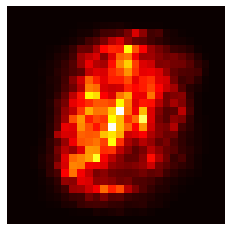

In [54]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)


### **Boosting**: 
Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its prede‐
cessor. There are many boosting methods available, but by far the most popular are **AdaBoost** (short for Adaptive Boosting) and **Gradient Boosting**.

 **Adaboost**:

  One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predic‐
tors focusing more and more on the hard cases. This is the technique used by AdaBoost.
For example, to build an AdaBoost classifier, a first base classifier (such as a Decision
Tree) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on...

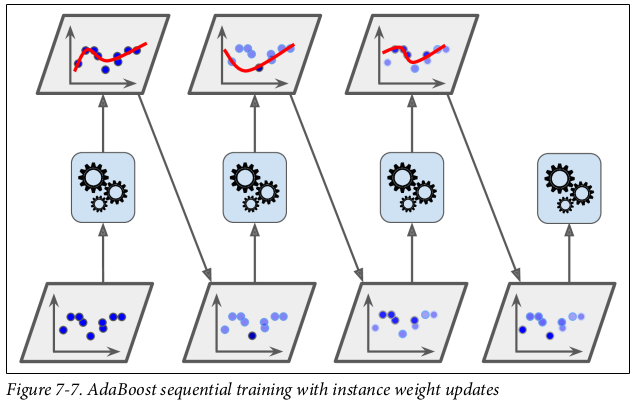
  

The following code shows the decision boundaries of five consecutive predictors on the
moons dataset (in this example, each predictor is a highly regularized SVM classifier
with an RBF kernel(**This is just for illustrative purposes. SVMs are generally not good base predictors for AdaBoost, because they
are slow and tend to be unstable with AdaBoost. **) ). 

The first classifier gets many instances wrong, so their weights get boosted. 

The second classifier therefore does a better job on these instances, and
so on. The plot on the right represents the same sequence of predictors except that
the learning rate is halved (i.e., the misclassified instance weights are boosted half as
much at every iteration). 

As we can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

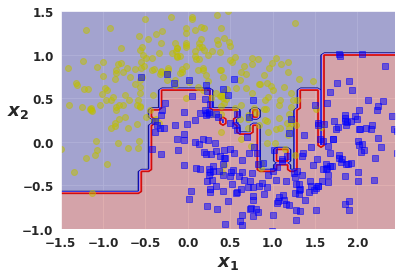

<Figure size 1152x432 with 0 Axes>

In [55]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

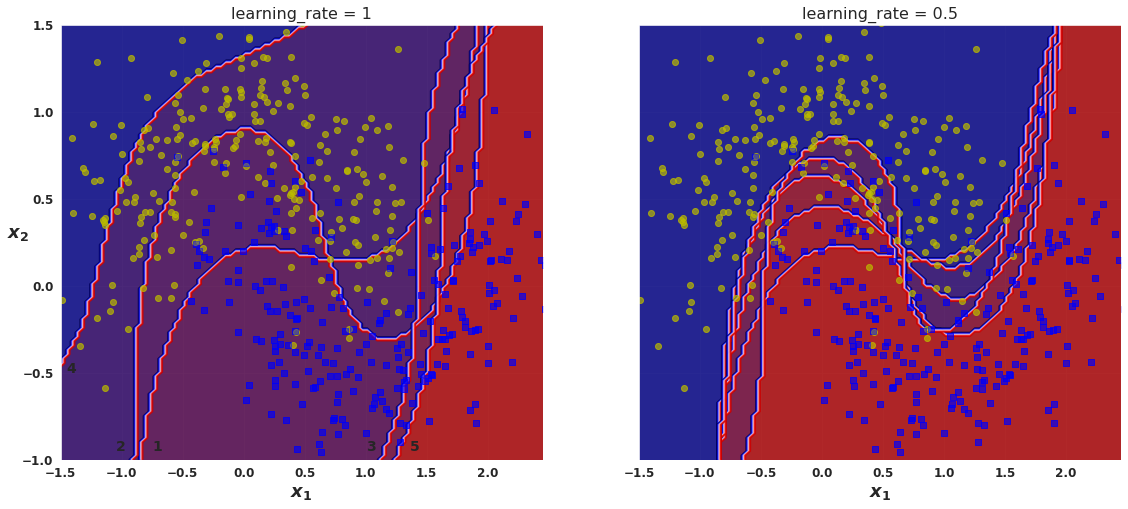

In [61]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(19,8), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their
overall accuracy on the weighted training set.


There is one important drawback to this sequential learning techni‐
que: it cannot be parallelized (or only partially), since each predic‐
tor can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bag‐
ging or pasting.



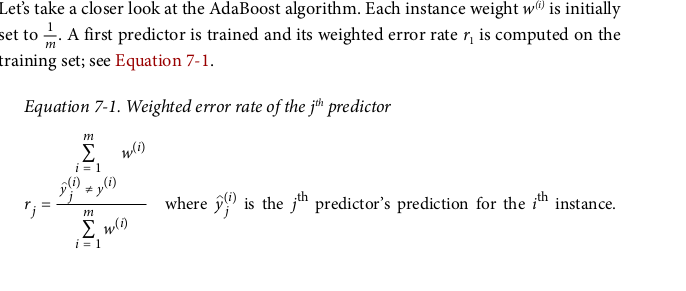



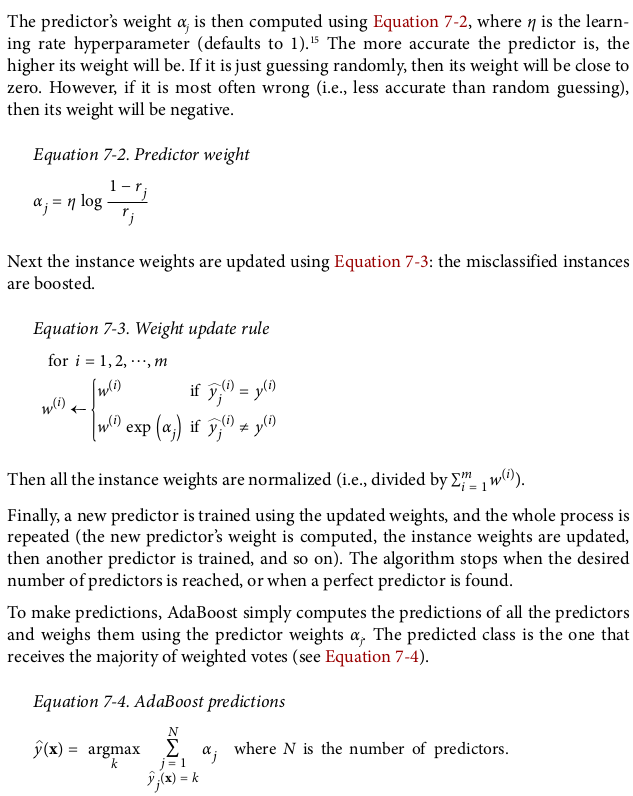

**If your AdaBoost ensemble is overfitting the training set, you can
try reducing the number of estimators or more strongly regularizing the base estimator.**

### **Gradient Boosting**:
  
   Another very popular Boosting algorithm is Gradient Boosting. 17 Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.
Let’s go through a simple regression example using Decision Trees as the base predic‐
tors (of course Gradient Boosting also works great with regression tasks). This is
called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s
fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic train‐
ing set):




In [62]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
#first tree:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

#second tree:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

#third tree:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

#make predictions:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred


array([0.75026781])

A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRe
gressor class. Much like the RandomForestRegressor class, it has hyperparameters to
control the growth of Decision Trees (e.g., max_depth , min_samples_leaf , and so on),
as well as hyperparameters to control the ensemble training, such as the number of
trees ( n_estimators ).

Text(0, 0.5, '$y$')

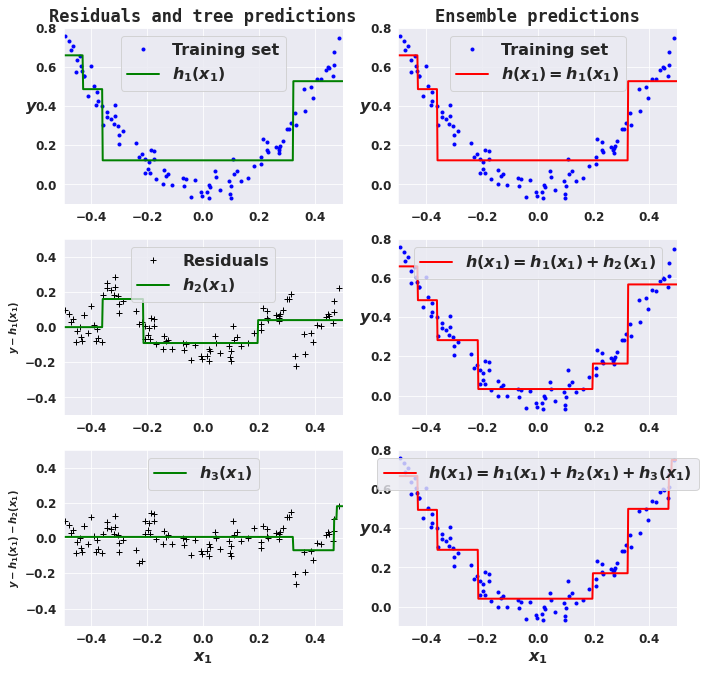

In [65]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=17,fontdict=font)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=17,fontdict=font)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=10)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=10)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

This represents the predictions of these three trees in the left column, and the
ensemble’s predictions in the right column. In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can
see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of
the second tree. You can see that the ensemble’s predictions gradually get better as
trees are added to the ensemble.

**This time using Gradient Boosting Regressor**

   A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRe
gressor class. Much like the RandomForestRegressor class, it has hyperparameters to
control the growth of Decision Trees (e.g., max_depth , min_samples_leaf , and so on),
as well as hyperparameters to control the ensemble training, such as the number of
trees ( n_estimators ). The following code creates the same ensemble as the previous
one:

Text(0.5, 0, '$x_1$')

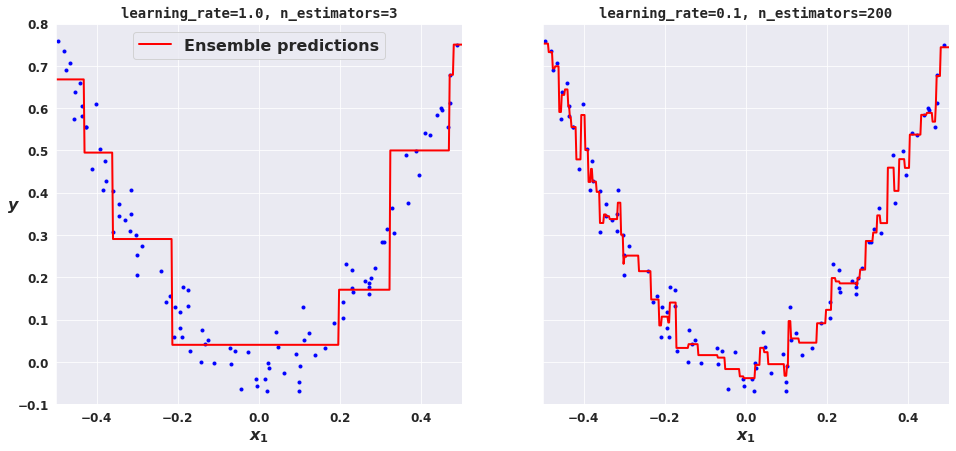

In [68]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(16,7), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14,fontdict=font)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14,fontdict=font)
plt.xlabel("$x_1$", fontsize=16)

The learning_rate hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1 , you will need more trees in the ensemble to fit the train‐
ing set, but the predictions will usually generalize better. This is a regularization tech‐
nique called shrinkage. The figure below shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

**gradient Boosting with Early stopping**:(**Tuning the number of trees using early stopping**)

 In order to find the optimal number of trees, you can use early stopping.
A simple way to implement this is to use the staged_predict() method: it
returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). 

The following code trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:

In [69]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Text(0.5, 0, '$x_1$')

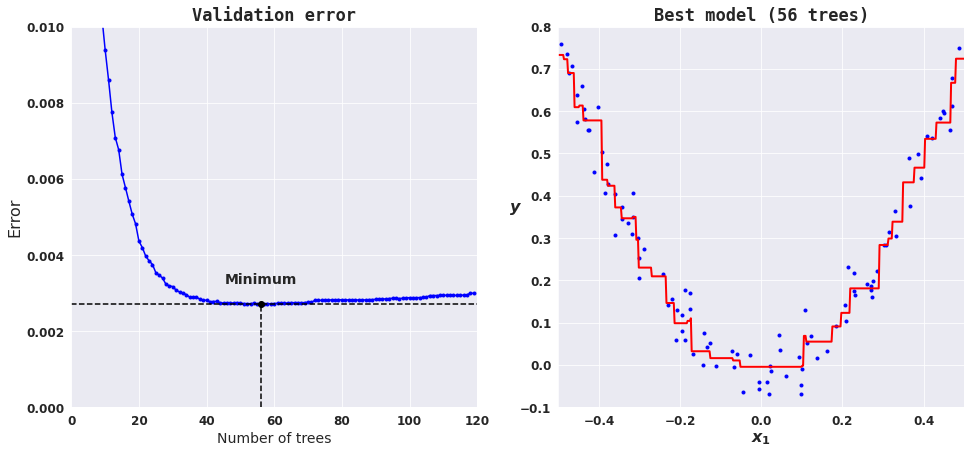

In [71]:
plt.figure(figsize=(16, 7))
min_error = np.min(errors)
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=17,fontdict=font)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=17,fontdict=font)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

**Second Approach for early stopping**:
  
  It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True , which makes Scikit-
Learn keep existing trees when the fit() method is called, allowing incremental
training. The following code stops training when the validation error does not
improve for five iterations in a row

In [72]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print('n_estimators',gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)



n_estimators 61
Minimum validation MSE: 0.002712853325235463


The GradientBoostingRegressor class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25 , then each tree is trained on 25% of the training instan‐
ces, selected randomly. As you can probably guess by now, this trades a higher bias
for a lower variance. It also speeds up training considerably. This technique is called
Stochastic Gradient Boosting.

**Xgboost**:

   It is worth noting that an optimized implementation of Gradient Boosting is available
in the popular python library XGBoost, which stands for Extreme Gradient Boosting.
This package was initially developed by Tianqi Chen as part of the Distributed (Deep)
Machine Learning Community (DMLC), and it aims at being extremely fast, scalable
and portable. In fact, XGBoost is often an important component of the winning
entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s.

In [73]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None


if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)    
           
# XGBoost also offers several nice features, such as automatically taking care of early stopping:
if xgboost is not None:  
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  
    print("Validation MSE:", val_error)                   

[18:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943
[18:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation

In [74]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [75]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 23.7 ms per loop
